In [1]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter
from skimage.util import invert
from skimage import color

In [248]:
# do wersji v1
import math 
import numpy as np
def get_line_lenght(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    return math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi

def get_angle_to_rotate_image(image):
    edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(edges, threshold=1, line_length=5, line_gap=3)
    longest_line = (lines[0],  get_line_lenght(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_lenght(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)

    angle = get_angle_of_line(longest_line[0])
    return angle

In [249]:
# do wersji v2
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny


def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

def check_if_perpendicular_lines(line1, line2):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
        if compare_2_numbers_with_range(angle_between_lines, 90, 5):
            return True
    
    return False

def get_base_line(img):
    edges = canny(img, 2, 1, 25)
    lines = probabilistic_hough_line(edges, threshold=1, line_length=int((img.shape[0]+img.shape[1])/10), line_gap=3)
    
    for line1 in lines:
        counter = 0
        for line2 in lines:
            if check_if_perpendicular_lines(line1, line2):
                counter += 1
        if counter >= 2:
            return line1
    
    return None
get_base_line(io.imread(images_paths[4]))

((183, 124), (88, 7))

In [236]:
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
def clear_images(images):
    images_cleared = list()
    for img in images:
        thresh = threshold_otsu(img)
        bw = closing(img > thresh, square(3))
        cleared = clear_border(bw)
        images_cleared.append(cleared)
    return images_cleared

def rotate_images(images):
    images_rotated = list()
    for image_path in images_paths:
        img = io.imread(image_path)
        angle = get_angle_to_rotate_image(img)
        img = rotate(img, angle)
        images_rotated.append(img)
    return images_rotated

def cut_images_sides(images):
    images_cut = list()
    for img in images:
        label_img = label(img, connectivity=2)
        biggest_region = regionprops(label_img)[0]
        for region in regionprops(label_img):
            if region.area > biggest_region.area:
                biggest_region = region

    #     x,y = rectangle_perimeter((1,biggest_region.bbox[1]), (img.shape[0]-2,biggest_region.bbox[3]))
    #     img = color.grey2rgb(img)
    #     img[x,y] = [255,0,0]
    #     images_rect.append(img)
        images_cut.append(img[:,biggest_region.bbox[1]:biggest_region.bbox[3]+1])
        
    return images_cut

In [251]:
# wersja używa najdłuższej linii w figurze jako podstawy
def rotate_scale_and_cut_v1(images_paths):
    images = [io.imread(path) for path in images_paths]
    images = clear_images(images)
    images = rotate_images(images)
    
    shape = images[0].shape
    images = [resize(img, shape) for img in images]
    
#     images = cut_images_sides(images)
    
    return images

# wersja szuka linii, które mają kąt prosty jako podstawa, chyba mniejsze zaufanie mam do tego
def rotate_and_scale_v2(images_paths):
    images_rotated = list()
    for image_path in images_paths:
        img = io.imread(image_path)
        base_line = get_base_line(img)
        angle = get_angle_of_line(base_line)
        img = rotate(img, angle)
        images_rotated.append(img)
        
    shape = images_rotated[0].shape
    images_resized = [resize(img, shape) for img in images_rotated]
    return images_resized

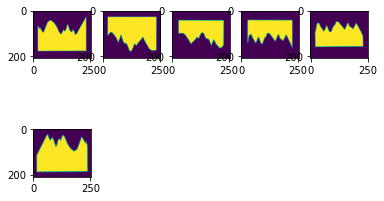

In [264]:
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set0', '')
images_paths = glob.glob(os.path.join(path, '*.png'))

images = rotate_scale_and_cut_v1(images_paths)
fig = plt.figure()
columns = 5
rows = (len(images_paths)/columns)+1
for i, img in enumerate(images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    
